In [1]:
# Librerie

import tensorflow as tf
import numpy as np
import os
import shutil
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.11.0


In [2]:
# Random seed

seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
main_folder = "/kaggle/input/algerian-used-cars/dataset/DATA"

# % di immagini nel test set
test_ratio = 0.1


for class_folder in os.listdir(main_folder):
    
    # Creazione percorsi cartelle classi
    class_folder_path = os.path.join(main_folder, class_folder)
    car_model = class_folder_path.split('/')[-1]
    

    if os.path.isdir(class_folder_path):
        # Cartelle di training 
        train_folder_path = "/kaggle/working/train/" + car_model
        test_folder_path = "/kaggle/working/test/" + car_model
        
        # Crea le cartelle se non esistono già
        os.makedirs(train_folder_path, exist_ok=True)
        os.makedirs(test_folder_path, exist_ok=True)
        
        # Loop attraverso le immagini nella cartella di classe
        for image_filename in os.listdir(class_folder_path):
            
            if image_filename.endswith('.jpg') or image_filename.endswith('.png'):
                # Genera un numero casuale tra 0 e 1 (per capire se inserire l'immagine nel test set)
                random_number = random.random()
                
                # Copia l'immagine nella cartella di training o di test in base al numero casuale
                if random_number < test_ratio:
                    # Copia l'immagine nella cartella di test
                    shutil.copy(os.path.join(class_folder_path, image_filename), os.path.join(test_folder_path, image_filename))
                else:
                    # Copia l'immagine nella cartella di training
                    shutil.copy(os.path.join(class_folder_path, image_filename), os.path.join(train_folder_path, image_filename))

In [4]:
data_dir = "/kaggle/working/train"

classes = []

# Loop attraverso le cartelle di classi
for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    car_model = class_folder_path.split('/')[-1]
    classes.append(car_model)
    
print(classes)

data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.,
                                                           validation_split=0.2)

train_gen = data_gen.flow_from_directory(directory=data_dir,
                                                           target_size=(128,128),
                                                           color_mode='rgb',
                                                           classes=classes,
                                                           class_mode='categorical',
                                                           batch_size=8,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset = 'training')
                                                           
valid_gen = data_gen.flow_from_directory(directory=data_dir,
                                               target_size=(128,128),
                                               color_mode='rgb',
                                               classes=classes,
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed,
                                               subset = 'validation')

['polo', 'logan', 'duster', 'volkswagen tiguan', 'octavia', 'clio', 'chevrolet spark', 'hyundai tucson', 'hyundai i10', 'megane', 'seat ibiza', 'toyota corolla', 'chevroulet aveo', 'symbol', 'picanto', 'sandero', 'nemo citroen', 'Golf', 'mercedes class a', 'bmw serie 1']
Found 2346 images belonging to 20 classes.
Found 576 images belonging to 20 classes.


In [5]:
# Dizionario che associa i numeri ai nomi delle classi (modelli macchine)
class_dict = {v: k for k, v in train_gen.class_indices.items()}

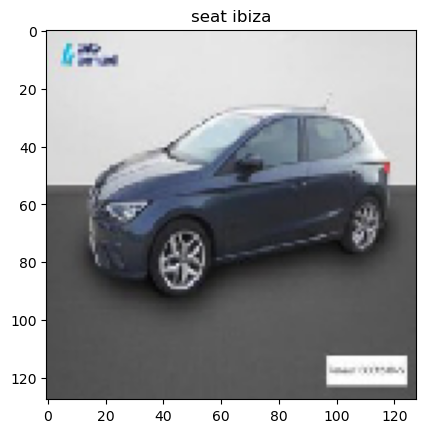

In [6]:
# Immagine esempio training set

images, labels = next(train_gen)

for i in range(1):
    plt.imshow(images[i])
    plt.title(class_dict[labels[i].argmax()])
    plt.show()

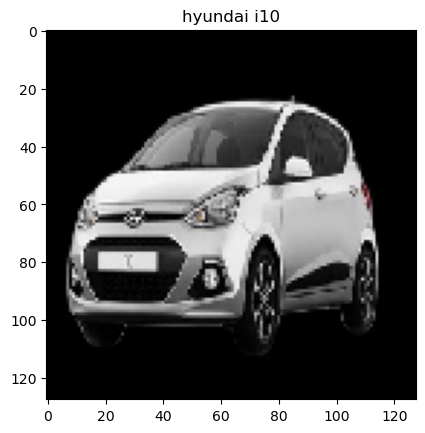

In [7]:
# Immagine esempio training set

images, labels = next(train_gen)

for i in range(1):
    plt.imshow(images[i])
    plt.title(class_dict[labels[i].argmax()])
    plt.show()

In [8]:
# Parametri modello e training
input_shape = (128, 128, 3)
epochs = 1000

In [9]:
# Funzione di costruzione del modello

def build_model(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    conv1 = tfkl.Conv2D(
        filters=16,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    
    pool1 = tfkl.MaxPooling2D()(conv1)

    conv2 = tfkl.Conv2D(
        filters=32,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool1)
    
    pool2 = tfkl.MaxPooling2D()(conv2)

    conv3 = tfkl.Conv2D(
        filters=64,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(pool2)
    
    pool3 = tfkl.MaxPooling2D()(conv3)

    global_average_pool = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(pool3)
    dropout = tfkl.Dropout(0.3, seed=seed)(global_average_pool)
    classifier_layer = tfkl.Dense(units=128, name='Classifier', kernel_initializer=tfk.initializers.HeUniform(seed), kernel_regularizer= tfk.regularizers.L1L2(l1=1e-5, l2=1e-4), activation='relu')(dropout)
    dropout = tfkl.Dropout(0.3, seed=seed)(classifier_layer)
    output_layer = tfkl.Dense(units=20, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), kernel_regularizer= tfk.regularizers.L1L2(l1=1e-5, l2=1e-4), name='output_layer')(dropout)

    # Connessione input-output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model1')

    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    
    return model

In [10]:
model = build_model(input_shape)
model.summary()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496

In [11]:
# Training del modello
history = model.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)]
).history

Epoch 1/1000
294/294 [==============================] - 14s 20ms/step - loss: 3.0192 - accuracy: 0.0835 - val_loss: 2.9508 - val_accuracy: 0.1076
Epoch 2/1000
294/294 [==============================] - 5s 18ms/step - loss: 2.9672 - accuracy: 0.0968 - val_loss: 2.9387 - val_accuracy: 0.0781
Epoch 3/1000
294/294 [==============================] - 5s 17ms/step - loss: 2.9519 - accuracy: 0.0980 - val_loss: 2.9285 - val_accuracy: 0.1076
Epoch 4/1000
294/294 [==============================] - 5s 18ms/step - loss: 2.9420 - accuracy: 0.1027 - val_loss: 2.9211 - val_accuracy: 0.1076
Epoch 5/1000
294/294 [==============================] - 5s 17ms/step - loss: 2.9161 - accuracy: 0.0963 - val_loss: 2.8969 - val_accuracy: 0.1094
Epoch 6/1000
294/294 [==============================] - 6s 20ms/step - loss: 2.8778 - accuracy: 0.1117 - val_loss: 2.8726 - val_accuracy: 0.1146
Epoch 7/1000
294/294 [==============================] - 5s 19ms/step - loss: 2.8493 - accuracy: 0.1134 - val_loss: 2.8908 - val_a

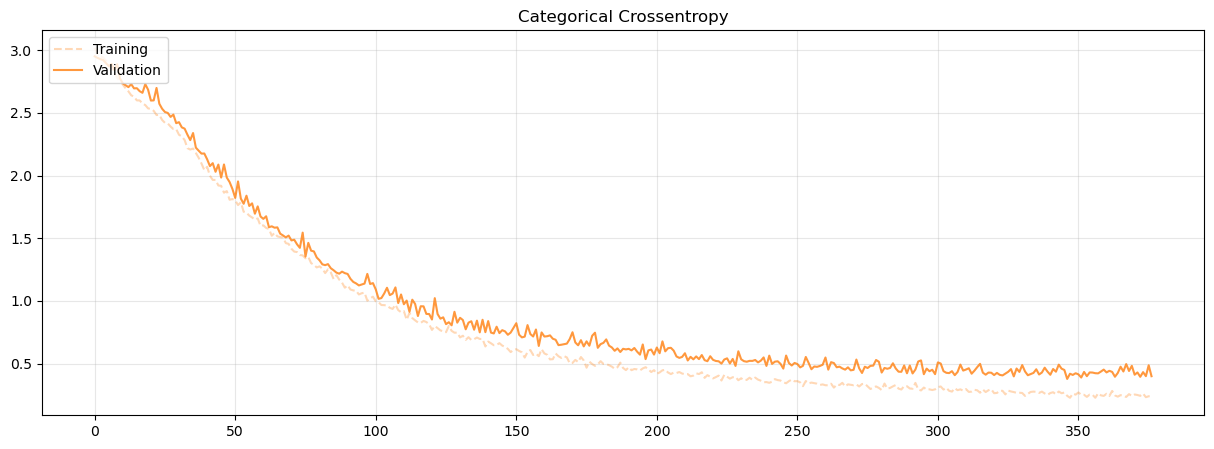

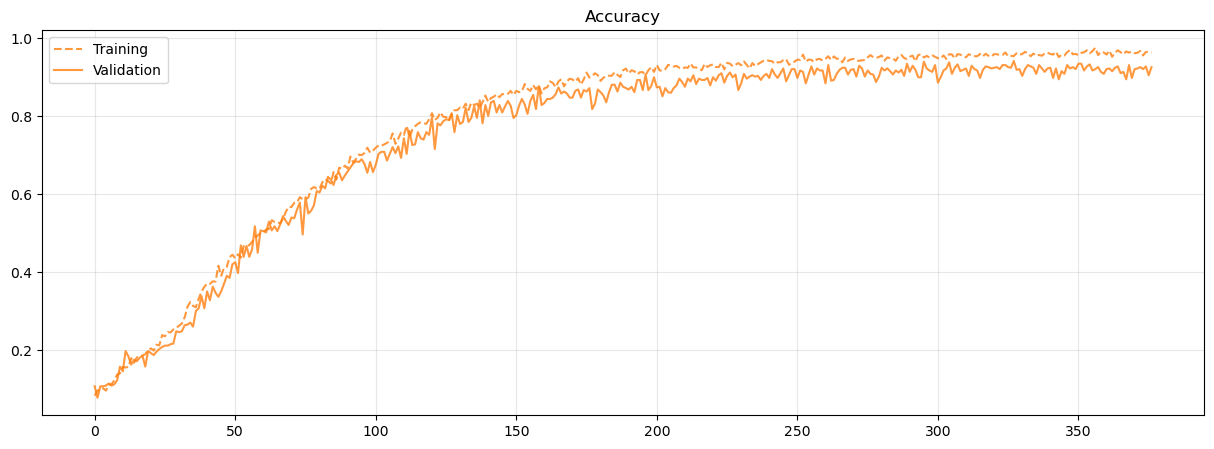

In [12]:
# Training info
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [16]:
# Test set

test_dir = "/kaggle/working/test"

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

test_ds = test_datagen.flow_from_directory(directory=test_dir,
                target_size=(128,128),
                color_mode='rgb',
                classes=classes,
                class_mode='categorical',
                batch_size=8,
                shuffle=True,
                seed=seed)

# Valutazione delle performance sul test set
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test set accuracy: {test_acc}")

Found 313 images belonging to 20 classes.
40/40 [==============================] - 1s 13ms/step - loss: 0.6433 - accuracy: 0.8658
Test set accuracy: 0.8658146858215332


1/1 [==============================] - 0s 103ms/step


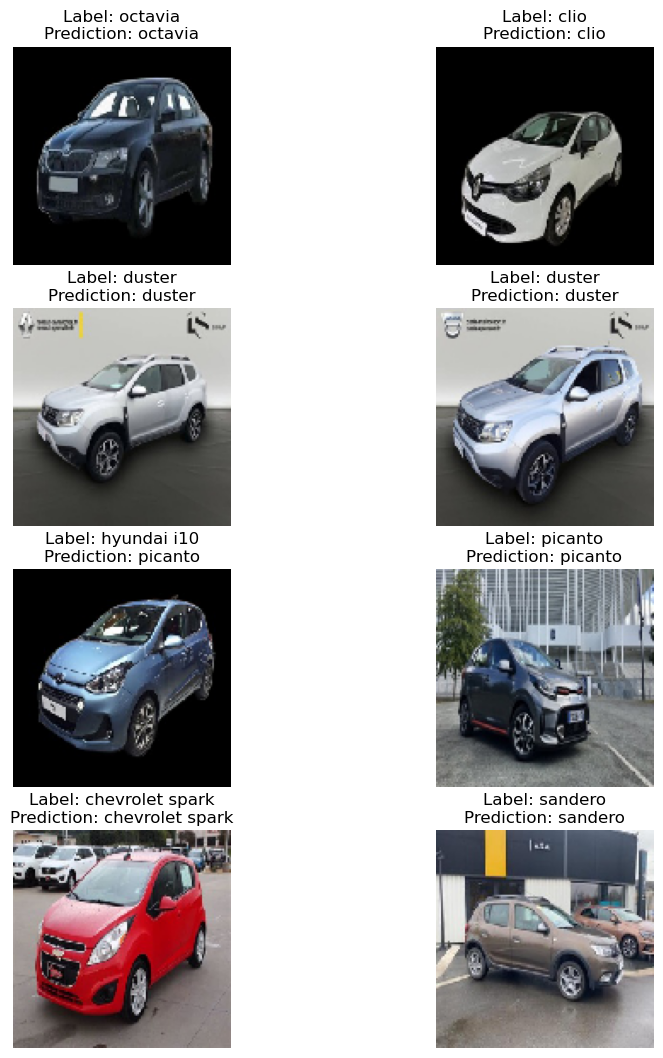

In [17]:
# Prova di riconoscimento sul test set

preds = model.predict(test_ds)

x_test, y_test = next(test_ds)

preds = model.predict(x_test)

fig, axs = plt.subplots(4, 2, figsize=(10, 13))
axs = axs.flatten()

for img, label, pred, ax in zip(x_test[:16], y_test[:16], preds[:16], axs):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title("Label: {}\nPrediction: {}".format(class_dict[np.argmax(label)], class_dict[np.argmax(pred)]))
    
plt.show()